In [25]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [50]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-unigram"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [28]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

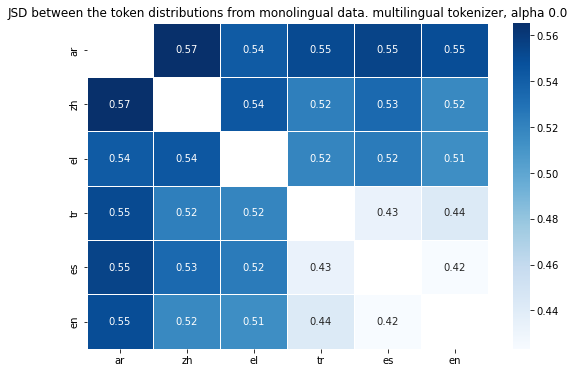

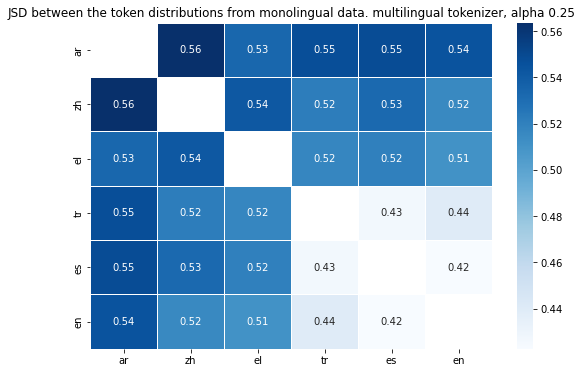

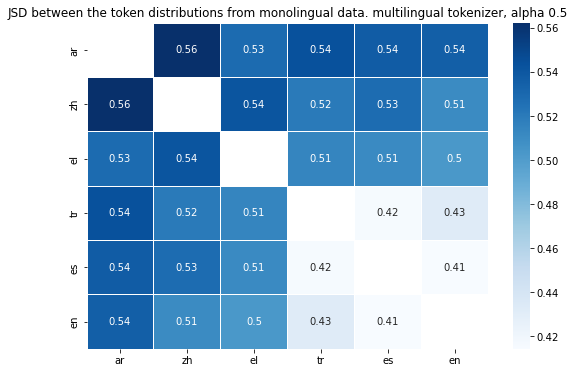

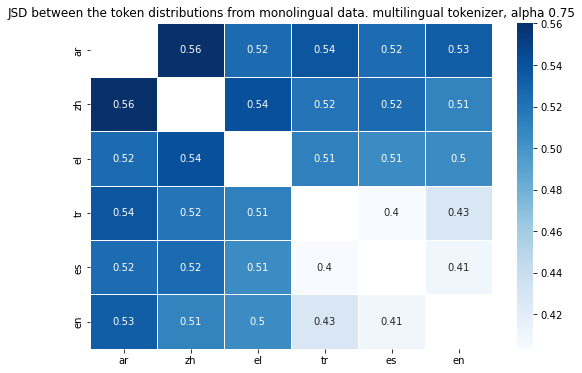

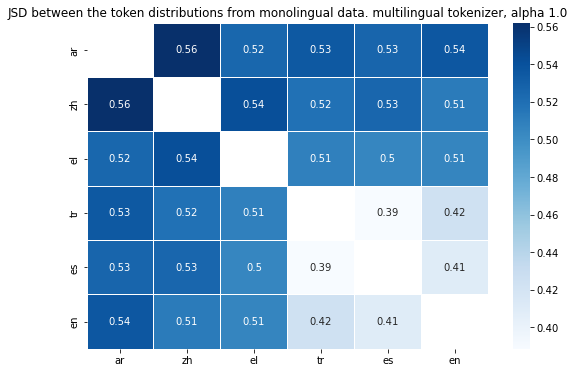

In [37]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2]) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

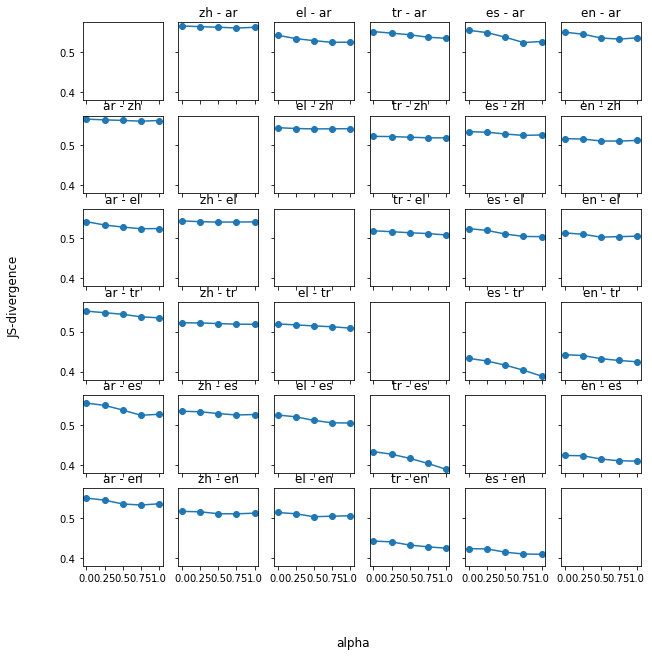

In [41]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


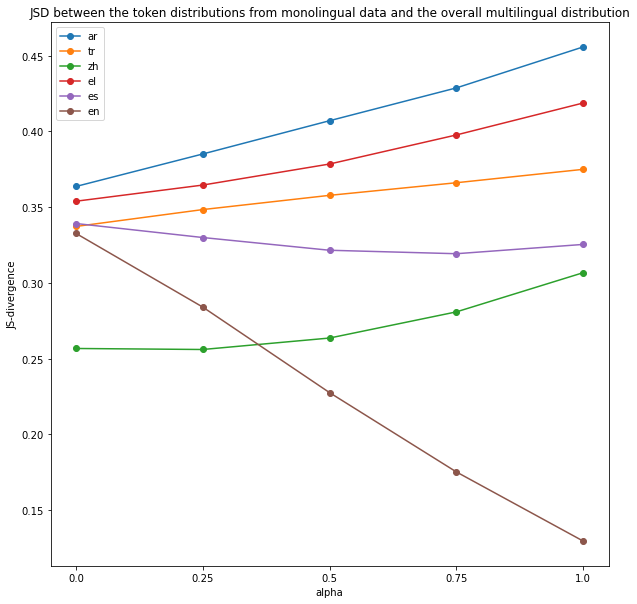

In [51]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha]) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

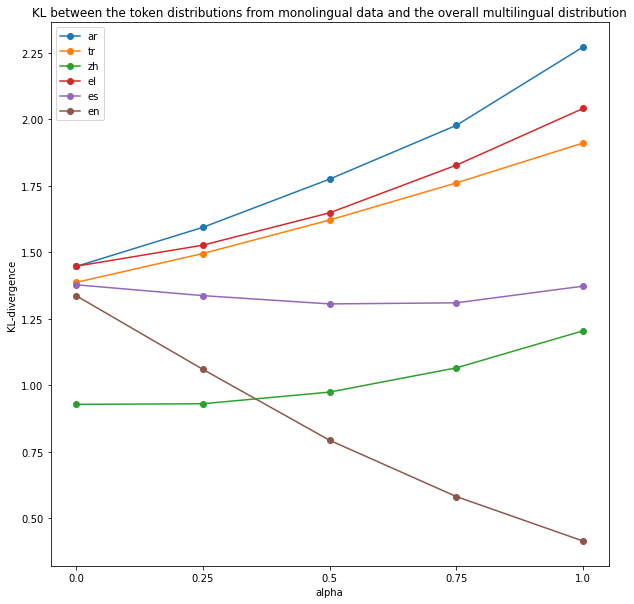

In [52]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha])

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()